# Dealing With Imbalanced Classes: SMOTE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
df = pd.read_excel('../data/default of credit card clients.xls') 
df = df.iloc[1:, 1:]
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
X = df.loc[:,'X1':'X23']
y = df.loc[:, 'Y'].astype('category')

In [4]:
from collections import Counter
Counter(y).items()

dict_items([(1, 6636), (0, 23364)])

In [5]:
from imblearn.over_sampling import SMOTE

X_smote, y_smote = SMOTE().fit_sample(X, y)
Counter(y_smote).items()

dict_items([(1, 23364), (0, 23364)])

In [59]:
df_SMOTE = X_smote.copy()
df_SMOTE['Y'] = y_smote
df_SMOTE.to_csv(r'../output/data_SMOTE.csv', index=False)

# Split the data into training and test sets

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_smote,
                                                 y_smote,
                                                 test_size=.25,
                                                 random_state=123)

# Decision Tree

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#params = {'max_depth':range(1,30)}
#gscv = GridSearchCV(DecisionTreeClassifier(), params, cv=10)
#gscv.fit(X_train,y_train)
#print(gscv.best_params_)

In [8]:
#best param output:{'max_depth': 10}

In [9]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train,y_train)

print(f'training accuracy: {dtc.score(X_train,y_train):0.4f}')
print(f'test accuracy: {dtc.score(X_test,y_test):0.4f}')
print(f'AUC: {roc_auc_score(y_test, dtc.predict(X_test)):0.4f}')

training accuracy: 0.8707
test accuracy: 0.8406
AUC: 0.8415


# Gradient Boosting without Feature Selection

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

#params = {'learning_rate':[0.1,0.05,0.01],
#          'n_estimators':[10,50,100],
#          'max_depth':[1,2,5,7],
#          'min_samples_split': [2,3,4],
#          'min_samples_leaf':[1,3,5]}
#gscv = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1)
#gscv.fit(X_train,y_train)
#print(gscv.best_params_)

In [11]:
# best params output{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}

In [12]:
gbc = GradientBoostingClassifier(learning_rate=0.1,
                                 max_depth=7,
                                 min_samples_leaf=1,
                                 min_samples_split=4,
                                 n_estimators=100,
                                 )
gbc.fit(X_train,y_train)

print(f'training accuracy: {gbc.score(X_train,y_train):0.4f}')
print(f'test accuracy: {gbc.score(X_test,y_test):0.4f}')
print(f'AUC: {roc_auc_score(y_test, gbc.predict(X_test)):0.4f}')

training accuracy: 0.9052
test accuracy: 0.8758
AUC: 0.8766


# Gradient Boosting with Feature Selection

X6     0.4115
X4     0.1167
X2     0.0862
X12    0.0654
X7     0.0551
X3     0.0501
X8     0.0325
X1     0.0183
X11    0.0173
X10    0.0169
X9     0.0165
X21    0.0129
X18    0.0127
X5     0.0122
X19    0.0104
X13    0.0100
X23    0.0097
X20    0.0090
X17    0.0077
X15    0.0072
X16    0.0072
X14    0.0072
X22    0.0072
dtype: float64

<AxesSubplot:>

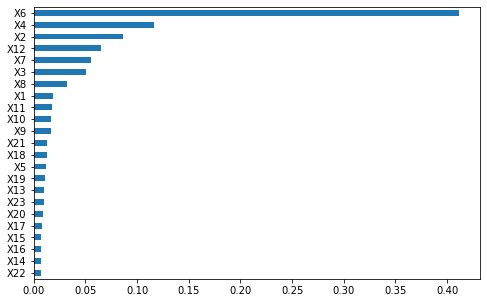

In [37]:
feature_importances = pd.Series(gbc.feature_importances_,index=X_train.columns)
display(feature_importances.sort_values(ascending=False).round(4))

fig,ax = plt.subplots(1,1,figsize=(8,5))
feature_importances.sort_values().plot.barh(ax=ax)

In [25]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(gbc,
                      threshold='mean',
                      prefit=True)

X_train.columns[sfm.get_support()]

Index(['X2', 'X3', 'X4', 'X6', 'X7', 'X12'], dtype='object')

In [28]:
X_train_fs = sfm.transform(X_train)
X_test_fs = sfm.transform(X_test)

In [39]:
#params = {'learning_rate':[0.1,0.05,0.01],
#          'n_estimators':[10,50,100],
#          'max_depth':[1,2,5,7],
#          'min_samples_split': [2,3,4],
#          'min_samples_leaf':[1,3,5]}
#gscv = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1)
#gscv.fit(X_train_fs,y_train)
#print(gscv.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
#best params output:{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}

In [40]:
gbc_fs = GradientBoostingClassifier(learning_rate=0.1,
                                 max_depth=5,
                                 min_samples_leaf=5,
                                 min_samples_split=2,
                                 n_estimators=100,
                                 )
gbc_fs.fit(X_train_fs,y_train)

print(f'training accuracy: {gbc_fs.score(X_train_fs,y_train):0.4f}')
print(f'test accuracy: {gbc_fs.score(X_test_fs,y_test):0.4f}')
print(f'AUC: {roc_auc_score(y_test, gbc_fs.predict(X_test_fs)):0.4f}')

training accuracy: 0.8785
test accuracy: 0.8701
AUC: 0.8710
